In [1]:
import pandas as pd
import pylcs
import numpy as np
from tqdm.notebook import tqdm
import sklearn.svm
import sklearn.kernel_ridge
import plotly.express as px
import sklearn.metrics
import sklearn.model_selection
import sklearn.manifold
import optuna
import scipy

In [2]:
import pylcs
import fasta
from pathlib import Path
from math import log2
import numpy as np
from collections import Counter
import pandas as pd

In [3]:
datadir = "ncBench/datasets/dataset2"
dataset_name = "ncRNA_dataset2"
sequence_files = [x for x in Path(datadir).glob("*.fasta")]
datasets = {fname.stem: fasta.FASTA(str(fname)) for fname in sequence_files}
{k: len(v) for k, v in datasets.items()}

{'train': 31801, 'train_test': 45447, 'test': 13646}

In [4]:
rows = []
rng = np.random.default_rng(23)
for subset in ["train", "test"]:
    fasta_dataset = datasets[subset]
    for seq in fasta_dataset.sequences.values():
        (id, label) = seq.description.split(" ", 2)
        validation = rng.uniform() < 0.2
        rows.append({"id": seq.id, "target": label, "sequence": str(seq.seq), "set": subset, "validation": validation})
split_df = pd.DataFrame(rows)
split_df

,id,target,sequence,set,validation
0,605,5S-rRNA,ATCTGATAGCTTCTCTGGATCCCAAAAGTTGCCAAATACCATCTAA...,train,False
1,9424,CD-box,TTCACTGATGATGATTATATTACCGCCCCAGTCTGATTTTATATTC...,train,False
2,20087,Riboswitch,CCGGATTGTCGATACCGTCGCGCCGTCGCGGTAACGGGAAGCCGGT...,train,True
3,14722,HACA-box,CGACTACAGCTCTCTGGATTCACTCTGGCCTTTCAATGCATGTGTT...,train,True
4,33739,tRNA,GCTCCTGTGGCCTAGTGGTGAGGGCATCCCTCTTATAAGGAATCTG...,train,False
...,...,...,...,...,...
45442,18742,Leader,GAAAAAGCGTTGAAAAGATGAGTAGTTTTGGATAGACTTATAGAGA...,test,False
45443,13516,HACA-box,TCCCAAGGTGTTGAGTTCAGTTCAGGGCTGCTTCCCTGTTCTGGTA...,test,False
45444,28677,miRNA,AAGGGGTGTCAAAGTAGAGGTAGGTGCGAGAAATGACGGGCATCGT...,test,True
45445,6156,CD-box,CGTCATGATTTGGGCATTGCATTAACTTATCATTAAAGTATGTTGA...,test,True


In [5]:
sequence_lengths = [len(x) for x in split_df["sequence"].tolist()]
np.min(sequence_lengths), np.max(sequence_lengths), np.median(sequence_lengths)

(42, 500, 123.0)

In [6]:
split_df[split_df["set"] == "test"]

,id,target,sequence,set,validation
31801,21355,Riboswitch,AATTAAAAAAGCGATGAGGCTCGCTTGAGATGTAATCAAACCGCCG...,test,False
31802,11684,HACA-box,ATCCTAGGTAAGCCCTTTAAACTACTTATCTGATTTATGGGAGACA...,test,True
31803,14551,HACA-box,AACTTTGTCCAAAAGTACTCCACCGCAATAGACAGTACGACGGCCG...,test,True
31804,6725,CD-box,TTGCCATGATGATTTCAAATTATTAGGAAAGCATTATGCTAATGCT...,test,False
31805,28222,miRNA,AATCTGGGAAGAGAGCTTCCTTCAGTCCACTCATGGGGAGTGGTAA...,test,False
...,...,...,...,...,...
45442,18742,Leader,GAAAAAGCGTTGAAAAGATGAGTAGTTTTGGATAGACTTATAGAGA...,test,False
45443,13516,HACA-box,TCCCAAGGTGTTGAGTTCAGTTCAGGGCTGCTTCCCTGTTCTGGTA...,test,False
45444,28677,miRNA,AAGGGGTGTCAAAGTAGAGGTAGGTGCGAGAAATGACGGGCATCGT...,test,True
45445,6156,CD-box,CGTCATGATTTGGGCATTGCATTAACTTATCATTAAAGTATGTTGA...,test,True


In [7]:
# rng = np.random.default_rng(23)
# train_size = 2**10
# test_size = 2**8
train_df = split_df[(split_df["set"] == "train") & (split_df["validation"] != True)]
# train_idx = rng.choice(len(train_df), size=train_size, replace=False)
# train_df = train_df.iloc[train_idx]
valid_df = split_df[(split_df["set"] == "train") & (split_df["validation"] == True)]
test_df = split_df[split_df["set"] == "test"]
# test_idx = rng.choice(len(test_df), size=test_size, replace=False)
# test_df = test_df.iloc[test_idx]

In [8]:
train_df

,id,target,sequence,set,validation
0,605,5S-rRNA,ATCTGATAGCTTCTCTGGATCCCAAAAGTTGCCAAATACCATCTAA...,train,False
1,9424,CD-box,TTCACTGATGATGATTATATTACCGCCCCAGTCTGATTTTATATTC...,train,False
4,33739,tRNA,GCTCCTGTGGCCTAGTGGTGAGGGCATCCCTCTTATAAGGAATCTG...,train,False
5,25199,miRNA,ACATTAATTGCCTGGGGATCTTGTTAAAATGTAGATTCTGGTTCAG...,train,False
6,33383,tRNA,GCGGCAGGCTCGGCTAGAGCCCCGGACTGATAATCCGGTGGTGGCG...,train,False
...,...,...,...,...,...
31796,20773,Riboswitch,AACTTAATAGATGTTAGAAGTTCTCAAGTATGTTAAAAAACTTGAA...,train,False
31797,11644,HACA-box,TGGTTGGAGCCAGATCCAACGCCTCATAAGTTAACTCACTGGTTGT...,train,False
31798,15785,Leader,AAAAATTCTGTGATAGGAAAGAGTAGTTAGAATGAAGTATTTAAAG...,train,False
31799,28125,miRNA,TAGGGTGACCAGCTCTCCCAGTTTGGTCAGGACTGAGGAGTTTCCT...,train,False


In [9]:
valid_df

,id,target,sequence,set,validation
2,20087,Riboswitch,CCGGATTGTCGATACCGTCGCGCCGTCGCGGTAACGGGAAGCCGGT...,train,True
3,14722,HACA-box,CGACTACAGCTCTCTGGATTCACTCTGGCCTTTCAATGCATGTGTT...,train,True
12,35779,5.8S-rRNA,GACTCTCGGCAACGGATATCTCGGCTCTCGCATCGATGAAGAACGT...,train,True
20,35280,Y-RNA,GACTGGTCCGAAGGCAGTGAGTTTTCTCCGCCGATTTCTCAGCCAA...,train,True
25,21251,Riboswitch,CATCACACCTCACGCGTGGGCATCACCAGGAATCCGGCGGAAATCC...,train,True
...,...,...,...,...,...
31782,11353,HACA-box,TCCCGGTTCTAGGCACGAACCGGGACATTGGTCCCGGTTCGTGCCT...,train,True
31784,9419,CD-box,CCAATTGGAGATGATGAGCTGGTGGCATTCATTCTCAATGGTTTGG...,train,True
31785,28805,miRNA,ACCAGTGGAGAAAAGGCAAGATGTTGGCATAGCTGTGATTTAAATA...,train,True
31792,33474,tRNA,GCCTGGGTAGCTCAATCGGTAGAGCGTGTGACTCTTACTTCCTTAT...,train,True


In [10]:
test_df

,id,target,sequence,set,validation
31801,21355,Riboswitch,AATTAAAAAAGCGATGAGGCTCGCTTGAGATGTAATCAAACCGCCG...,test,False
31802,11684,HACA-box,ATCCTAGGTAAGCCCTTTAAACTACTTATCTGATTTATGGGAGACA...,test,True
31803,14551,HACA-box,AACTTTGTCCAAAAGTACTCCACCGCAATAGACAGTACGACGGCCG...,test,True
31804,6725,CD-box,TTGCCATGATGATTTCAAATTATTAGGAAAGCATTATGCTAATGCT...,test,False
31805,28222,miRNA,AATCTGGGAAGAGAGCTTCCTTCAGTCCACTCATGGGGAGTGGTAA...,test,False
...,...,...,...,...,...
45442,18742,Leader,GAAAAAGCGTTGAAAAGATGAGTAGTTTTGGATAGACTTATAGAGA...,test,False
45443,13516,HACA-box,TCCCAAGGTGTTGAGTTCAGTTCAGGGCTGCTTCCCTGTTCTGGTA...,test,False
45444,28677,miRNA,AAGGGGTGTCAAAGTAGAGGTAGGTGCGAGAAATGACGGGCATCGT...,test,True
45445,6156,CD-box,CGTCATGATTTGGGCATTGCATTAACTTATCATTAAAGTATGTTGA...,test,True


In [11]:
# Export sequences to text file in order to compute LCS in parallel
# After runnig this cell, use the pairwise_distances.py script to compute (upper triangular part of symmetric) LCS matrices.
# The script supports options for computing submatrices, to be used for distributing the computation on a cluster. The simplest example is:
# $ python3 pairwise_distances.py sequences_ncRNA_dataset2.txt sequences_ncRNA_dataset2.npy
# Then use the notebook "Assemble Distance Matrices.npy" to assemble submatrices and compute the 
# lower triangular entries. Output the result into a file "lcs_ncRNA_dataset2.npy"

all_sequences = [x.sequence for x in split_df.itertuples()]
with open(f"sequences_{dataset_name}.txt", "w+") as fh:
    for seq in all_sequences:
        fh.write(seq)
        fh.write("\n")

In [12]:
# This cell assumes that LCS matrices have been generated using the external script, as described in the previous cell

lcs_matrix = np.load(f"lcs_{dataset_name}.npy").astype("uint16")
lcs_matrix

array([[123,  54,  91, ...,  65,  73,  89],
       [ 54,  74,  59, ...,  52,  59,  63],
       [ 91,  59, 186, ...,  77,  79, 104],
       ...,
       [ 65,  52,  77, ...,  97,  63,  74],
       [ 73,  59,  79, ...,  63, 108,  82],
       [ 89,  63, 104, ...,  74,  82, 156]], dtype=uint16)

In [13]:
harmonic_series = np.hstack([[0], np.cumsum(1/np.arange(1, 2**20))])
def compute_harmonic_edit_distance(la, lb, lcs):
    return 2*harmonic_series[la+lb-lcs] - harmonic_series[la] - harmonic_series[lb]

def compute_edit_distance(la, lb, lcs):
    return la+lb-2*lcs

def compute_steinhaus_distance(la, lb, lcs):
    ed = compute_edit_distance(la, lb, lcs)
    return 2*ed / (la + lb + ed)

def extract_lcs(lcs_matrix, row_df, col_df):
    row_seqs = [x.sequence for x in row_df.itertuples()]
    col_seqs = [x.sequence for x in col_df.itertuples()]
    lcs = np.zeros((len(row_seqs), len(col_seqs)), dtype="uint16")
    col_idx = np.array(col_df.index.values, dtype=int)
    for i in range(len(row_seqs)):
            k_i = row_df.index[i]
            lcs[i, :] = lcs_matrix[k_i, col_idx]
    return lcs

def extract_dataset(lcs_matrix, train_df, df):
    dataset = {}
    dataset["sequences"] = [x.sequence for x in df.itertuples()]
    dataset["lengths"] = np.array([len(x) for x in dataset["sequences"]])
    train_lengths = np.array([len(x.sequence) for x in train_df.itertuples()])
    dataset["target"] = df["target"]
    dataset["lcs"] = extract_lcs(lcs_matrix, df, train_df).astype("uint16")
    dataset["harmonic_distance"] = compute_harmonic_edit_distance(
        dataset["lengths"][:, None], 
        train_lengths[None, :], 
        dataset["lcs"]
    )
    dataset["edit_distance"] = compute_edit_distance(
        dataset["lengths"][:, None], 
        train_lengths[None, :], 
        dataset["lcs"]
    )
    dataset["steinhaus_distance"] = compute_steinhaus_distance(
        dataset["lengths"][:, None], 
        train_lengths[None, :], 
        dataset["lcs"]
    )
    return dataset

In [14]:
train = extract_dataset(lcs_matrix, train_df, train_df)
valid = extract_dataset(lcs_matrix, train_df, valid_df)
test = extract_dataset(lcs_matrix, train_df, test_df)

In [15]:
train["lcs"].nbytes / 2**20

1227.7367420196533

In [16]:
train["harmonic_distance"].nbytes / 2**20

4910.946968078613

In [17]:
import optuna

In [18]:
def eval_parameters(params, distance_key, train, eval):
    gamma = params["gamma"]
    C = params["C"]

    train["kernel"] = np.exp(-gamma*train[distance_key]**2)
    eval["kernel"] = np.exp(-gamma*eval[distance_key]**2)

    classifier = sklearn.svm.SVC(C=C, kernel="precomputed", verbose=False, shrinking=False, max_iter=2**16)
    classifier.fit(train["kernel"], train["target"])

    prediction = classifier.predict(eval["kernel"])
    valid_accuracy = sklearn.metrics.accuracy_score(eval["target"], prediction)

    # valid_spearman = scipy.stats.spearmanr(prediction, eval["target"]).statistic
    return valid_accuracy

In [19]:
def objective(trial, distance_key, train, eval, gamma_range=[1e-1, 1e1]):
    params = {}
    params["gamma"] = trial.suggest_float("gamma", gamma_range[0], gamma_range[1], log=True)
    params["C"] = trial.suggest_float("C", 1e-2, 1e2, log=True)
    val = eval_parameters(params, distance_key, train, eval)
    return -val

In [20]:
eval_parameters({"C": 1, "gamma": 1}, "harmonic_distance", train, valid)

0.9003110419906687

In [21]:
def objective_harmonic(trial):
    return objective(trial, "harmonic_distance", train, valid, gamma_range=[1e-1, 1e1])

def objective_edit(trial):
    return objective(trial, "edit_distance", train, valid, gamma_range=[1e-4, 1e-2])

def objective_steinhaus(trial):
    return objective(trial, "steinhaus_distance", train, valid, gamma_range=[1e-1, 1e1])

In [22]:
studies = {}
study = optuna.create_study()
study.optimize(objective_harmonic, n_trials=16)
studies["harmonic"] = study

[I 2024-08-07 13:05:20,562] A new study created in memory with name: no-name-20b5dc68-1acd-4e5d-8bb4-05cd7e83364d
[I 2024-08-07 13:05:32,120] Trial 0 finished with value: -0.8435458786936236 and parameters: {'gamma': 0.5590928946019317, 'C': 0.10014277970437574}. Best is trial 0 with value: -0.8435458786936236.
[I 2024-08-07 13:05:40,890] Trial 1 finished with value: -0.6888024883359254 and parameters: {'gamma': 6.97131947457495, 'C': 0.023285039866720644}. Best is trial 0 with value: -0.8435458786936236.
[I 2024-08-07 13:05:49,425] Trial 2 finished with value: -0.8273716951788491 and parameters: {'gamma': 0.37932891193397006, 'C': 0.11292637708831474}. Best is trial 0 with value: -0.8435458786936236.
[I 2024-08-07 13:05:58,035] Trial 3 finished with value: -0.629393468118196 and parameters: {'gamma': 0.33891155438389403, 'C': 0.02030318931949949}. Best is trial 0 with value: -0.8435458786936236.
[I 2024-08-07 13:06:06,254] Trial 4 finished with value: -0.6776049766718507 and parameter

In [23]:
study = optuna.create_study()
study.optimize(objective_edit, n_trials=16)
studies["edit"] = study

[I 2024-08-07 13:07:44,609] A new study created in memory with name: no-name-9cd10df0-7285-4b56-98d6-4c6c62f754cb
[I 2024-08-07 13:08:04,566] Trial 0 finished with value: -0.44027993779160185 and parameters: {'gamma': 0.0008767593763542728, 'C': 0.08852146221779614}. Best is trial 0 with value: -0.44027993779160185.
[I 2024-08-07 13:08:15,744] Trial 1 finished with value: -0.8762052877138413 and parameters: {'gamma': 0.0001239784846391118, 'C': 2.6688410242918548}. Best is trial 1 with value: -0.8762052877138413.
[I 2024-08-07 13:08:27,786] Trial 2 finished with value: -0.4121306376360809 and parameters: {'gamma': 0.0005708853472031703, 'C': 0.018438777411391598}. Best is trial 1 with value: -0.8762052877138413.
[I 2024-08-07 13:08:41,520] Trial 3 finished with value: -0.8043545878693623 and parameters: {'gamma': 0.0004202938454396966, 'C': 9.646437293395863}. Best is trial 1 with value: -0.8762052877138413.
[I 2024-08-07 13:08:58,870] Trial 4 finished with value: -0.38475894245723175 

In [24]:
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=23))
study.optimize(objective_steinhaus, n_trials=32)
studies["steinhaus"] = study

[I 2024-08-07 13:11:18,471] A new study created in memory with name: no-name-df762c97-c98b-4fc8-be5b-038ea47c2f10
[I 2024-08-07 13:11:49,484] Trial 0 finished with value: -0.8626749611197512 and parameters: {'gamma': 1.0829184866889259, 'C': 61.35506425409843}. Best is trial 0 with value: -0.8626749611197512.
[I 2024-08-07 13:11:58,403] Trial 1 finished with value: -0.919751166407465 and parameters: {'gamma': 3.395623408235136, 'C': 0.1347669426130217}. Best is trial 1 with value: -0.919751166407465.
[I 2024-08-07 13:12:06,464] Trial 2 finished with value: -0.9068429237947123 and parameters: {'gamma': 0.27675197352313574, 'C': 5.557613501759315}. Best is trial 1 with value: -0.919751166407465.
[I 2024-08-07 13:12:13,696] Trial 3 finished with value: -0.8530326594090202 and parameters: {'gamma': 0.2159128083221639, 'C': 0.37133840345513924}. Best is trial 1 with value: -0.919751166407465.
[I 2024-08-07 13:12:22,001] Trial 4 finished with value: -0.9332814930015552 and parameters: {'gamm

In [25]:
eval_parameters(studies["harmonic"].best_params, "harmonic_distance", train=train, eval=test)

0.9731789535394988

In [26]:
eval_parameters(studies["edit"].best_params, "edit_distance", train=train, eval=test)

0.8913967462992819

In [27]:
eval_parameters(studies["steinhaus"].best_params, "steinhaus_distance", train=train, eval=test)

0.9702476916312472

In [35]:
{k: v.best_params for k, v in studies.items()}

{'harmonic': {'gamma': 6.832409815910085, 'C': 2.2223349276745106},
 'edit': {'gamma': 0.00024040398039496064, 'C': 1.068830749423383},
 'steinhaus': {'gamma': 9.91793899262693, 'C': 1.485844877379199}}

In [28]:
tsne = sklearn.manifold.TSNE(metric="precomputed", n_iter=2**11, init="random", n_jobs=-1, verbose=True, random_state=42)
coordinates = {}
coordinates["harmonic"] = tsne.fit_transform(train["harmonic_distance"])


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 25371 samples in 0.230s...
[t-SNE] Computed neighbors for 25371 samples in 5.861s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25371
[t-SNE] Computed conditional probabilities for sample 2000 / 25371
[t-SNE] Computed conditional probabilities for sample 3000 / 25371
[t-SNE] Computed conditional probabilities for sample 4000 / 25371
[t-SNE] Computed conditional probabilities for sample 5000 / 25371
[t-SNE] Computed conditional probabilities for sample 6000 / 25371
[t-SNE] Computed conditional probabilities for sample 7000 / 25371
[t-SNE] Computed conditional probabilities for sample 8000 / 25371
[t-SNE] Computed conditional probabilities for sample 9000 / 25371
[t-SNE] Computed conditional probabilities for sample 10000 / 25371
[t-SNE] Computed conditional probabilities for sample 11000 / 25371
[t-SNE] Computed conditional probabilities for sample 12000 / 25371
[t-SNE] Computed conditional probabilities for sam

In [29]:
tsne = sklearn.manifold.TSNE(metric="precomputed", n_iter=2**11, init="random", n_jobs=-1, verbose=True, random_state=42)
coordinates["edit"] = tsne.fit_transform(train["edit_distance"])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 25371 samples in 0.290s...
[t-SNE] Computed neighbors for 25371 samples in 5.817s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25371
[t-SNE] Computed conditional probabilities for sample 2000 / 25371
[t-SNE] Computed conditional probabilities for sample 3000 / 25371
[t-SNE] Computed conditional probabilities for sample 4000 / 25371
[t-SNE] Computed conditional probabilities for sample 5000 / 25371
[t-SNE] Computed conditional probabilities for sample 6000 / 25371
[t-SNE] Computed conditional probabilities for sample 7000 / 25371
[t-SNE] Computed conditional probabilities for sample 8000 / 25371
[t-SNE] Computed conditional probabilities for sample 9000 / 25371
[t-SNE] Computed conditional probabilities for sample 10000 / 25371
[t-SNE] Computed conditional probabilities for sample 11000 / 25371
[t-SNE] Computed conditional probabilities for sample 12000 / 25371
[t-SNE] Computed conditional probabilities for sam

In [30]:
tsne = sklearn.manifold.TSNE(metric="precomputed", n_iter=2**11, init="random", n_jobs=-1, verbose=True, random_state=42)
coordinates["steinhaus"] = tsne.fit_transform(train["steinhaus_distance"])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 25371 samples in 0.235s...
[t-SNE] Computed neighbors for 25371 samples in 5.476s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25371
[t-SNE] Computed conditional probabilities for sample 2000 / 25371
[t-SNE] Computed conditional probabilities for sample 3000 / 25371
[t-SNE] Computed conditional probabilities for sample 4000 / 25371
[t-SNE] Computed conditional probabilities for sample 5000 / 25371
[t-SNE] Computed conditional probabilities for sample 6000 / 25371
[t-SNE] Computed conditional probabilities for sample 7000 / 25371
[t-SNE] Computed conditional probabilities for sample 8000 / 25371
[t-SNE] Computed conditional probabilities for sample 9000 / 25371
[t-SNE] Computed conditional probabilities for sample 10000 / 25371
[t-SNE] Computed conditional probabilities for sample 11000 / 25371
[t-SNE] Computed conditional probabilities for sample 12000 / 25371
[t-SNE] Computed conditional probabilities for sam

In [31]:
label_color_mapping = {lbl: i for i, (lbl, _) in enumerate(Counter(train["target"]).most_common())}

In [32]:
import plotly.graph_objs as go
traces = []
label_colors = [label_color_mapping[lbl] for lbl in train["target"]]
text = train["target"]
for distance, coords in coordinates.items():
    traces.append({"x": coords[:, 0], "y": coords[:, 1], "name": distance, "type": "scatter", "mode": "markers", "text": text, "marker": {"size": 2, "color": label_colors}})
layout = {"coloraxis": {"showscale": True}}
# go.Figure(data=traces[0:1], layout=layout).show()
# go.Figure(data=traces[1:2], layout=layout).show()

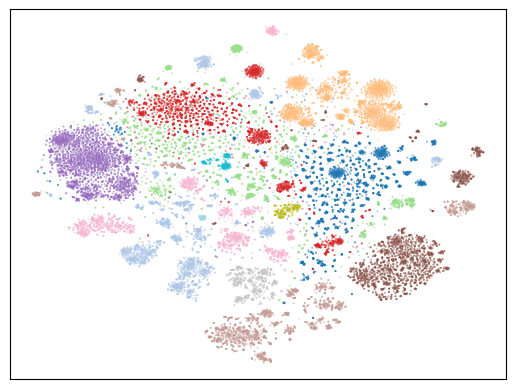

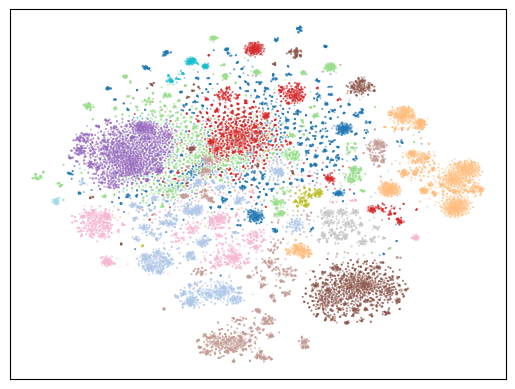

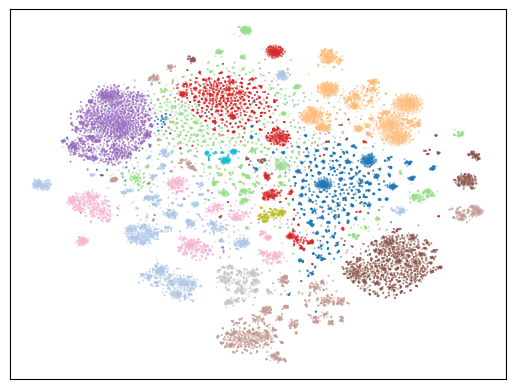

In [33]:
import matplotlib.pyplot as plt
import matplotlib as mpl
cmap = mpl.colormaps["tab20"]
for trace in traces: #trace = traces[0]
    fig, ax = plt.subplots()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.scatter(x=trace["x"], y=trace["y"], c=[int(x) for x in trace["marker"]["color"]], s=trace["marker"]["size"], alpha=0.5, edgecolor="none", cmap=cmap)
    plt.savefig(f"TSNE_{dataset_name}_{trace['name']}.png", dpi=600, bbox_inches="tight")

In [34]:
len(cmap.colors), train_df["target"].nunique()

(20, 13)